# GRADCAM

**Import Libraries and modules**

Let's start with a pretrained VGG model

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2

1) Loading helper functions

2) Load VGG

3) Load Image

4) Rescale image to 224x224x3 (VGG's expectation, why?)

5) Use expand_dims to convert image to a batch of size 1

6) Preprocesing normalizes our input image by subtracting mean RGB values

In [0]:
model = VGG16(weights="imagenet")

W0713 09:09:37.785006 140673070483328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0713 09:09:37.811458 140673070483328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0713 09:09:37.816115 140673070483328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0713 09:09:37.856075 140673070483328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0713 09:09:39.696662 140673070483328 deprecation_wrapp

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
from skimage import io
tony_stark = io.imread("https://github.com/bomila/eip3/blob/master/tony_stark_avenger3.jpg?raw=true")
tony_stark = cv2.resize(tony_stark, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(tony_stark)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

* We get the predictions for the image

* We take the topmost class index

* **Take output from the final convolutional layer**

In [0]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv3")


837


* Compute the gradient of the class output value with respect to the feature map

* Pool the gradients over all the axies leaving out the channel dimension

* Weigh the output feature map with the computed gradient values

In [0]:
import keras.backend as K
grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

(?, 14, 14, 512)
(512,)



1) Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14

2) Normalize the heat map to make the values between 0 and 1

In [0]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(14, 14, 512)
(14, 14)


**Show the results**

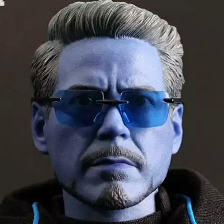

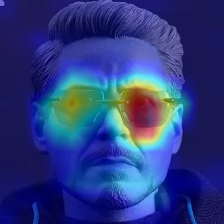

In [0]:
heatmap = cv2.resize(heatmap, (tony_stark.shape[1], tony_stark.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(tony_stark, 0.5, heatmap, 0.5, 0)
from google.colab.patches import cv2_imshow
cv2_imshow( tony_stark)
cv2_imshow(superimposed_img)

**Take output of one layer before the final convolutional layer**

In [0]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv2")


837


* Compute the gradient of the class output value with respect to the feature map

* Pool the gradients over all the axies leaving out the channel dimension

* Weigh the output feature map with the computed gradient values

In [0]:
import keras.backend as K
grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

(?, 14, 14, 512)
(512,)


In [0]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(14, 14, 512)
(14, 14)


**Show the result**

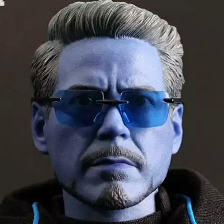

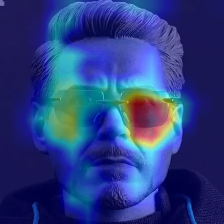

In [0]:
heatmap = cv2.resize(heatmap, (tony_stark.shape[1], tony_stark.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(tony_stark, 0.5, heatmap, 0.5, 0)
from google.colab.patches import cv2_imshow
cv2_imshow( tony_stark)
cv2_imshow(superimposed_img)

**Take output of two layer before the final convolutional layer and show gradcam image**

In [0]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv1")


837


* Compute the gradient of the class output value with respect to the feature map

* Pool the gradients over all the axies leaving out the channel dimension

* Weigh the output feature map with the computed gradient values

In [0]:
import keras.backend as K
grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

(?, 14, 14, 512)
(512,)


In [0]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(14, 14, 512)
(14, 14)


**Show result**

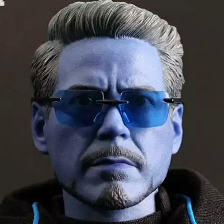

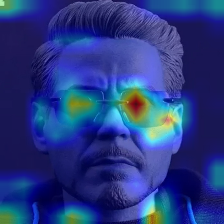

In [0]:
heatmap = cv2.resize(heatmap, (tony_stark.shape[1], tony_stark.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(tony_stark, 0.5, heatmap, 0.5, 0)
from google.colab.patches import cv2_imshow
cv2_imshow( tony_stark)
cv2_imshow(superimposed_img)

# Assignment 10 B

The network receptive field is calculated by the formula:

 **ϕi = ϕi−1 + (2^(η−τ))
∗ (Filter size −ϕi -1)**

Where η and τ are the number of strided convolutions and deconvolutional layers used in the network respectively.

Here, in convolution6 layer,

ϕi = 29

η=3

τ=1

Filter size=3

putting this value in formula,

 **ϕi = 29 + (2^(3-1))
∗ (3-1) = 29+4*4 = 45** 

so, receptive field = 45